In [1]:
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    visualize_dataloader,
)
from tree_detection_framework.detection.detector import GeometricDetector
from tree_detection_framework.postprocessing.postprocessing import (
    merge_and_postprocess_detections,
    multi_region_hole_suppression,
    single_region_hole_suppression,
    multi_region_NMS,
)
import time

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/chm.tif",
    chip_size=512,
    chip_stride=400,
    batch_size=3,
    output_resolution=0.2,
)

2024-12-21 00:32:55,613 - INFO - Units = Units.PIXELS
2024-12-21 00:32:55,613 - INFO - Stride = 400


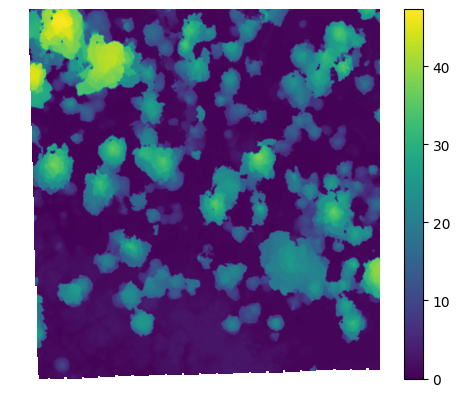

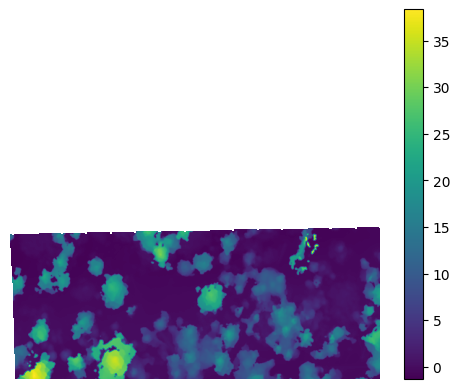

In [3]:
visualize_dataloader(dataloader, 2)

Create GeometricDetector and get predictions
--

Experiementing time taken with different filter_shapes

In [4]:
detector = GeometricDetector(
    a=0.0045, res=dataloader.sampler.res, confidence_factor="distance", filter_shape="square"
)

start_time = time.time()
predictions = detector.predict(dataloader)
end_time = time.time()
print(f"Time taken to get predictions using filter_shape SQUARE : {end_time - start_time} seconds")


Performing prediction on batches: 100%|██████████| 6/6 [00:37<00:00,  6.33s/it]

Time taken to get predictions using filter_shape SQUARE : 37.98792362213135 seconds


In [5]:
detector = GeometricDetector(
    a=0.0045, res=dataloader.sampler.res, confidence_factor="distance", filter_shape="circle"
)
start_time = time.time()
predictions = detector.predict(dataloader)
end_time = time.time()
print(f"Time taken to get predictions using filter_shape CIRCLE : {end_time - start_time} seconds")

Performing prediction on batches: 100%|██████████| 6/6 [00:41<00:00,  6.96s/it]

Time taken to get predictions using filter_shape CIRCLE : 41.744245767593384 seconds


In [6]:
detector = GeometricDetector(
    a=0.0045, res=dataloader.sampler.res, confidence_factor="distance", filter_shape="none"
)

start_time = time.time()
predictions = detector.predict(dataloader)
end_time = time.time()
print(f"Time taken to get predictions using filter_shape NONE (bruteforce) : {end_time - start_time} seconds")

Performing prediction on batches:   0%|          | 0/6 [00:00<?, ?it/s]2024-12-21 00:34:46,426 - INFO - No filter applied to the image. Using brute-force method.
2024-12-21 00:34:53,346 - INFO - No filter applied to the image. Using brute-force method.
2024-12-21 00:35:01,592 - INFO - No filter applied to the image. Using brute-force method.
Performing prediction on batches:  17%|█▋        | 1/6 [00:24<02:04, 24.97s/it]2024-12-21 00:35:11,383 - INFO - No filter applied to the image. Using brute-force method.
2024-12-21 00:35:13,020 - INFO - No filter applied to the image. Using brute-force method.
2024-12-21 00:35:20,739 - INFO - No filter applied to the image. Using brute-force method.
Performing prediction on batches:  33%|███▎      | 2/6 [00:44<01:27, 21.95s/it]2024-12-21 00:35:31,215 - INFO - No filter applied to the image. Using brute-force method.
2024-12-21 00:35:41,137 - INFO - No filter applied to the image. Using brute-force method.
2024-12-21 00:35:42,959 - INFO - No filter 

Time taken to get predictions using filter_shape NONE (bruteforce) : 95.6857442855835 seconds


Plotting the raw predictions before post-processing
--

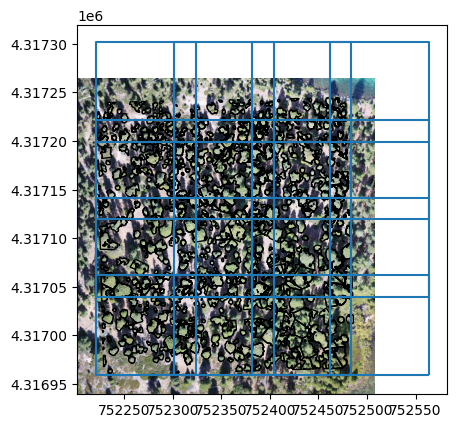

<Axes: >

In [7]:
predictions.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

NMS
---

In [8]:
postprocessed = multi_region_NMS(predictions)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
2024-12-21 00:36:55,477 - INFO - Bound have overlap, running across-region NMS
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


NMS with "distance"
--

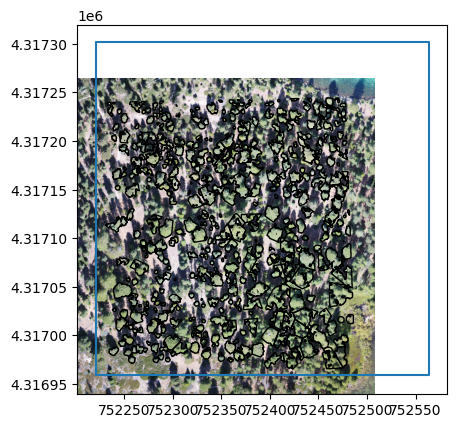

In [9]:
postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

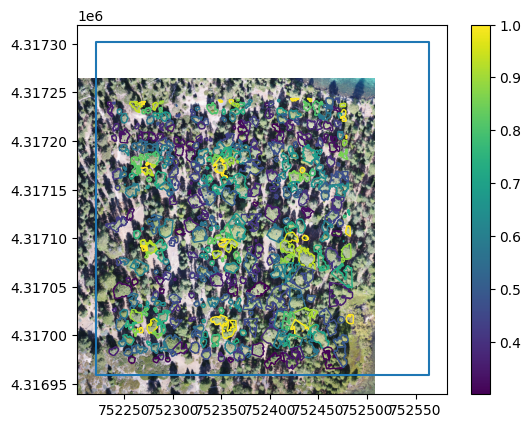

In [7]:
# Visualizing score column
postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif",
    visualization_column="score",
)

Note how higher confidence detections (yellow) are in the centers of each sub-grid/tile

NMS with "area"
--

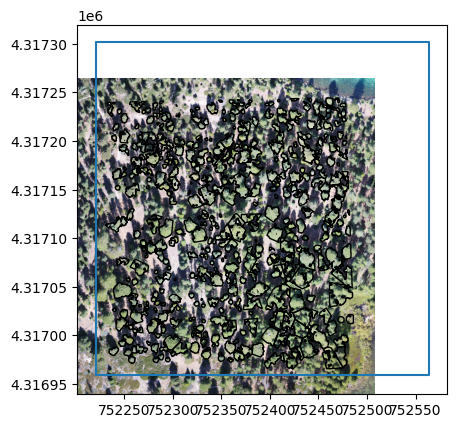

<Axes: >

In [9]:
postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

NMS with "height"
--

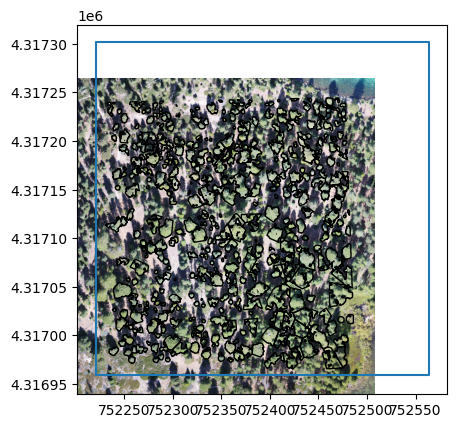

<Axes: >

In [10]:
postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

After suppressing polygon holes
--

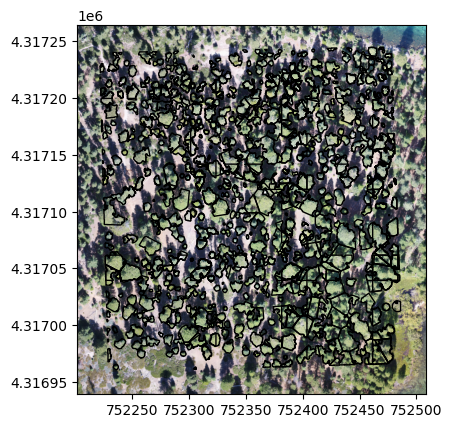

<Axes: >

In [8]:
hole_suppressed = multi_region_hole_suppression(predictions)

hole_suppressed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

Another way to post-process: Merging and simplifying crowns
---
This performs polygon hole supression within the function

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


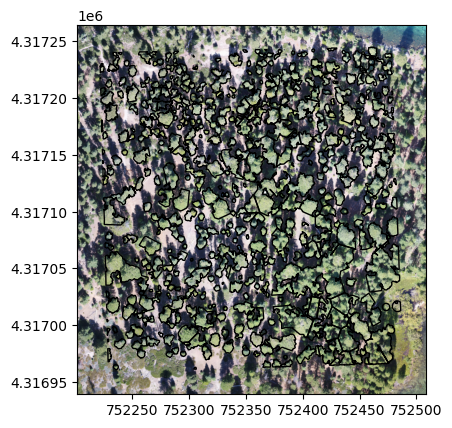

In [9]:
postprocessed = merge_and_postprocess_detections(predictions)

postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

In [ ]:
postprocessed.save(
    "/ofo-share/repos-amritha/extras/tdf/output_gpkgs/geometric_detections_multipolygon_filtered.gpkg"
)

2024-12-05 20:20:01,667 - INFO - Created 547 records


Single region hole suppression
--

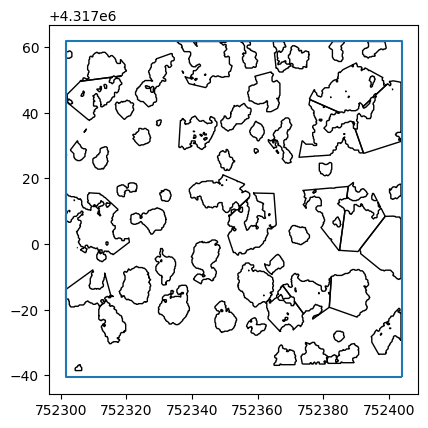

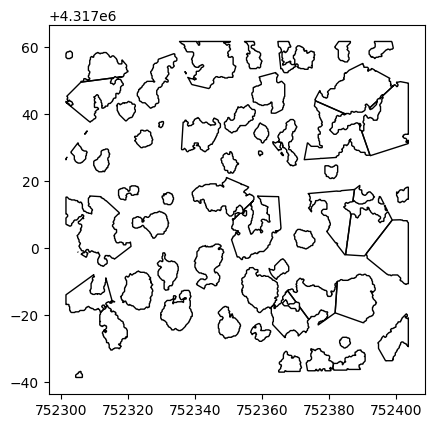

In [ ]:
# Get a RegionDetections object
region = predictions.region_detections[1]
region.plot()  # Before

postprocessed_region = single_region_hole_suppression(region)
postprocessed_region.plot()  # After